# Churchland Widefield Data

This notebook demonstrates:
- Decoding L/R choice from different periods of the delay period

Run this with access to the engram

In [1]:
# Import statements

import numpy as np
import pandas as pd
import ssm
import re
import seaborn as sns
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy.linalg as la
from collections import OrderedDict
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from ssm import LDS
from Session import *
from LVM import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
from matplotlib.cm import get_cmap
cmap = get_cmap('coolwarm')

## 1. Fit LR models for all sessions

In [3]:
window_lengths = [2,4,6]
task = "vistrained"
taskdir = "/home/chingf/engram/data/musall/" + task + "/"
def train_models(task, animal, day):
    """
    Fits and returns logistic regression models.
    
    Args:
        task: "vistrained" or "audtrained"
        animal: Name of the animal
        day: date of the session
    """
    
    # Load session and data
    session = Session(task, animal, day, access_engram=True, load_behavenet=False)
    delay_period_indices = session.get_delay_period(include_stim=True)
    all_neural_data = session.neural['neural']
    delay_data = []
    min_delay_size = 90
    for trial in range(delay_period_indices.shape[0]):
        start = delay_period_indices[trial,:][0] - 30
        end = delay_period_indices[trial,:][0] + 90
        delay_activity = all_neural_data[trial, start:end, :]
        delay_data.append(delay_activity)
    delay_data = np.array(delay_data)
    trial_choices = session.trialmarkers['ResponseSide']
    
    # Do a grid search over start index and window length
    # Fit logistic regression models
    all_results = []
    for window_length in window_lengths:
        start_idxs = range(0, delay_data.shape[1], 2)
        window_results = [None for _ in range(session.num_bins)]
        for start_idx in start_idxs:
            log_reg = fit_LR(start_idx, window_length, delay_data, trial_choices)
            window_results[start_idx] = log_reg
        all_results.append(window_results)
        
    # Collect the cross-validated accuracy
    accuracy_grid = []
    for idx, window_length in enumerate(window_lengths):
        window_results = all_results[idx]
        window_accuracy = []
        for results in window_results:
            if results == None:
                window_accuracy.append(0)#np.isnan)
                continue
            score = np.max(np.mean(results.scores_[1], axis=0))
            window_accuracy.append(score)
        accuracy_grid.append(window_accuracy)
    accuracy_grid = np.array(accuracy_grid)
    
    return all_results, accuracy_grid

In [4]:
def fit_LR(start_idx, window_length, data, trial_choices):
    """
    Fits a L2-regularized logistic regression model, predicting
    left/right licking choice.
    
    Args
        start_idx: index in delay period to start extracting a window
            of activity.
        window_length: size of the window of activity to extract
    """
    
    X = []
    y = []
    # Extracting training and test data
    for trial in range(trial_choices.size):
        choice = trial_choices[trial]
        if np.isnan(choice):
            continue
        activity = data[trial,start_idx:start_idx+window_length,:]
        X.append(activity.flatten())
        y.append(int(choice-1))
    X = np.array(X)
    y = np.array(y)
    
    # Training the model with cross validation
    log_reg = LogisticRegressionCV(
        Cs=5, cv=5, scoring='accuracy',
        max_iter=300
        )
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    log_reg.fit(X, y)
    return log_reg

In [5]:
# Run logistic regression over all available sessions
all_results = {}
all_accuracy = []
for animal in os.listdir(taskdir):
    if not animal.startswith("mSM"):
        continue
    animaldir = taskdir + animal + "/"
    all_results[animal] = {}
    for day in os.listdir(animaldir):
        if not re.match("\d{2}-\w+-\d{4}", day):
            print("Invalid directory: " + day)
            continue
        daydir = animaldir + day + "/"
        session_results, session_accuracy = train_models(task, animal, day)
        all_results[animal][day] = session_results

Invalid directory: .DS_Store
Invalid directory: .DS_Store


/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

Invalid directory: .DS_Store
Invalid directory: .DS_Store


/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

Invalid directory: .DS_Store


/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

In [6]:
# Save the logistic regression models
pickle.dump(all_results, open("temporaldecoding_all.p", "wb" ) )

## 2. Decoding: Which time periods are most predictive?
### Features: flattened neural activity

In [4]:
# If already available, load the logistic regression models
with open("temporaldecoding_all.p", "rb") as f:
    all_results = pickle.load(f)

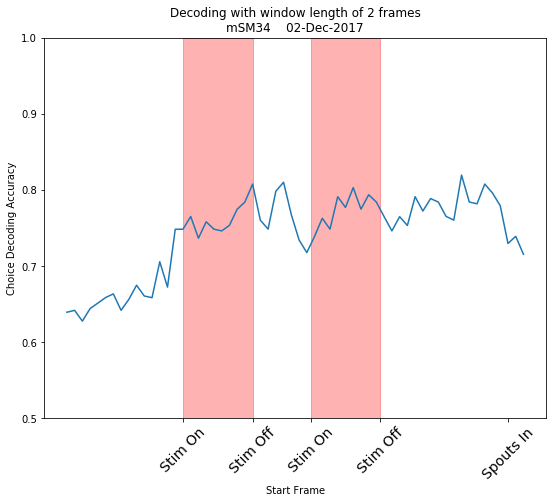

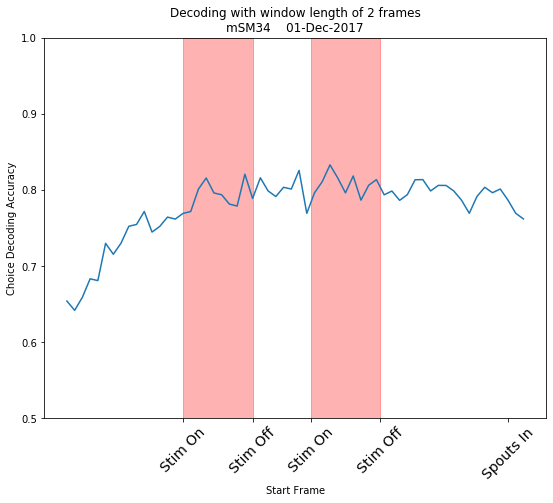

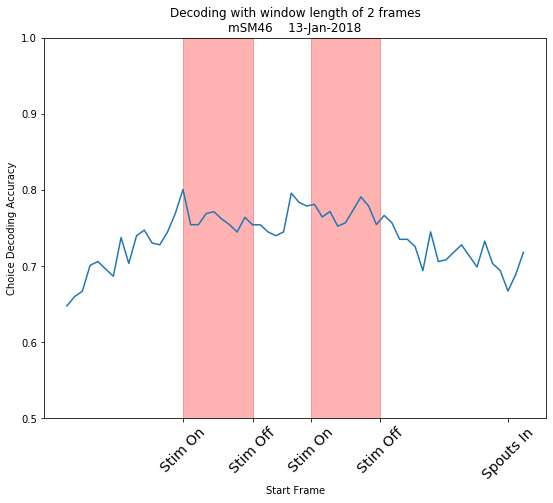

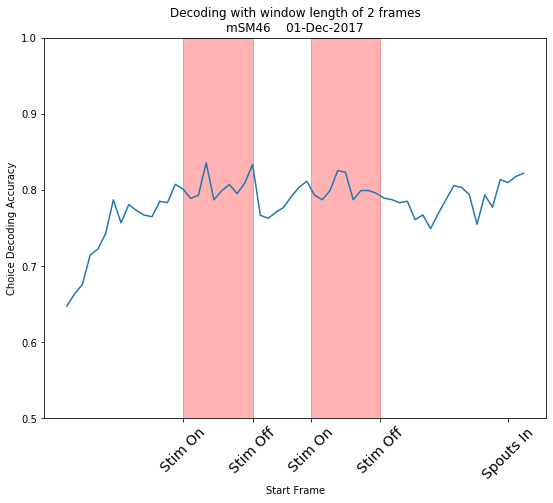

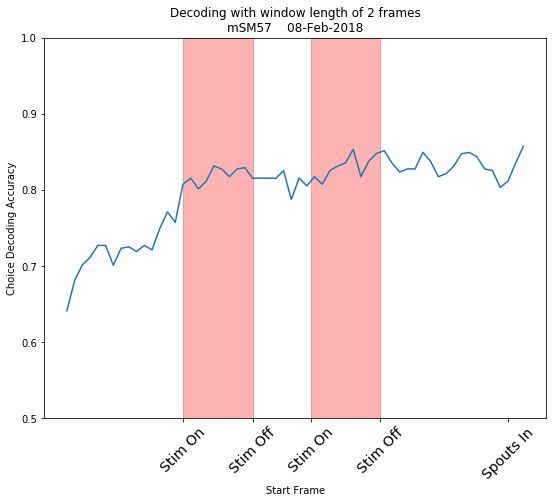

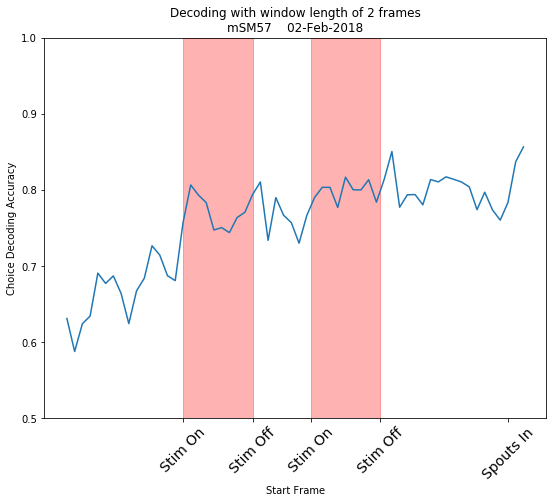

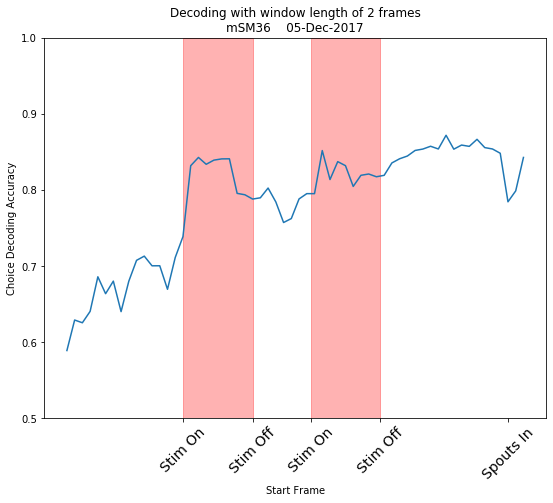

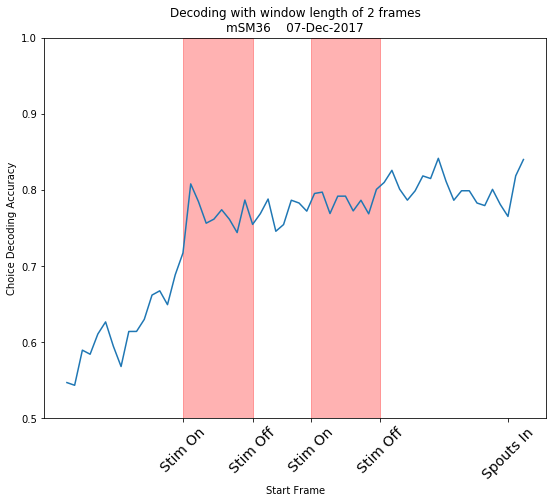

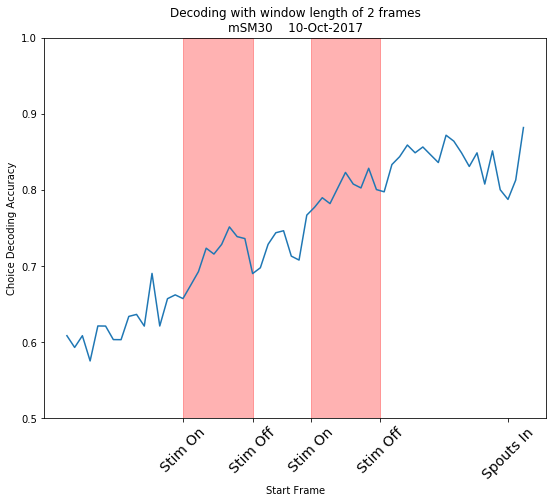

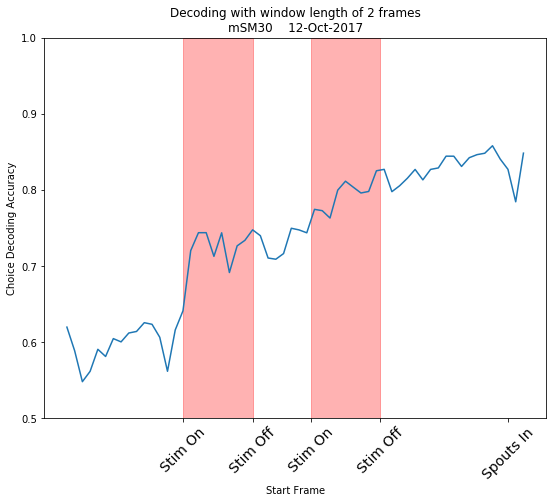

In [39]:
# Collect and plot the 'accuracy grid' of each session
all_accuracy = []
for k1 in all_results.keys():
    for k2 in all_results[k1].keys():
        results = all_results[k1][k2]
        # Collect the cross-validated accuracy
        accuracy_grid = []
        for idx, window_length in enumerate(window_lengths):
            window_results = results[idx]
            window_accuracy = []
            for r in window_results:
                if r == None:
                    window_accuracy.append(0)#np.isnan)
                    continue
                score = np.max(np.mean(r.scores_[1], axis=0))
                window_accuracy.append(score)
            accuracy_grid.append(window_accuracy)
        accuracy_grid = np.array(accuracy_grid)
        all_accuracy.append(accuracy_grid)
        
#         # Plot the cross-validated accuracy
#         plt.figure(figsize=(10,8))
#         plt.imshow(accuracy_grid, cmap=cmap, aspect='auto', clim=(0.5, 1))
#         plt.colorbar()
#         plt.xlabel("Start Frame")
#         plt.ylabel("Framesize of Window")
#         plt.yticks(
#             ticks=np.arange(len(window_lengths)),
#             labels=[1*w for w in window_lengths]
#             )
#         plt.xticks(
#             ticks=np.arange(1, accuracy_grid.shape[1], 10),
#             labels=np.arange(1, accuracy_grid.shape[1], 10)
#             )
#         plt.title("Logistic Regression Accuracy\n" + k1 + "    " + k2)
#         plt.show()

        # Visualize accuracy just for window lengths of 2
        plt.figure(figsize=(9,7))
        accuracy = []
        start_frame = []
        for idx, val in enumerate(accuracy_grid[0,:]):
            if val == 0:
                continue
            accuracy.append(val)
            start_frame.append(idx)
        plt.plot(start_frame, accuracy)
        plt.title("Decoding with window length of 2 frames\n" + k1 + "    " + k2)
        plt.ylabel("Choice Decoding Accuracy")
        plt.xlabel("Start Frame")
        plt.xticks(
            ticks=[30, 30+18, 30+33, 30+51, 30+84],
            labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
            rotation=45, fontsize=14
            )
        plt.axvspan(30, 30+18, alpha=0.3, color='red')
        plt.axvspan(30+33, 30+51, alpha=0.3, color='red')
        plt.ylim((0.5,1))
        plt.show()

In [6]:
# Get the mean accuracy grid
mean_accuracy = np.zeros((len(window_lengths), 120))
accuracy_counts = np.zeros(mean_accuracy.shape)
for accuracy in all_accuracy:
    for i in range(accuracy.shape[0]):
        for j in range(120):
            mean_accuracy[i][j] += accuracy[i][j]
            accuracy_counts[i][j] += 1

mean_accuracy = np.divide(mean_accuracy, accuracy_counts)

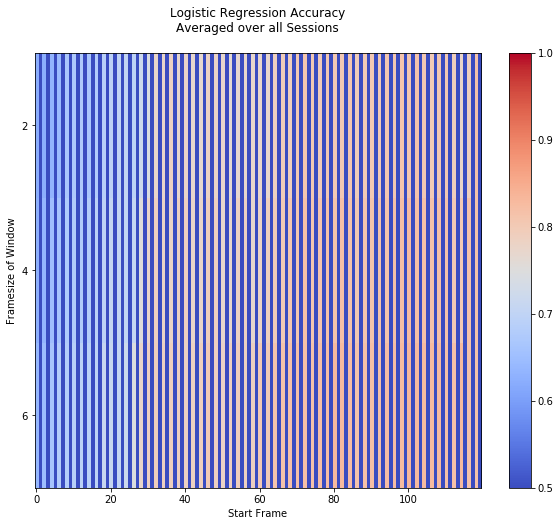

In [7]:
# Plot the cross-validated accuracy
plt.figure(figsize=(10,8))
plt.imshow(mean_accuracy, cmap=cmap, aspect='auto', clim=(0.5, 1))
plt.colorbar()
plt.xlabel("Start Frame")
plt.ylabel("Framesize of Window")
plt.yticks(
    ticks=np.arange(len(window_lengths)),
    labels=[1*w for w in window_lengths]
    )
plt.title("Logistic Regression Accuracy\nAveraged over all Sessions\n")
plt.show()

## 3. Decoding: Which regions are most predictive?
### Using window frames of length 2 frames

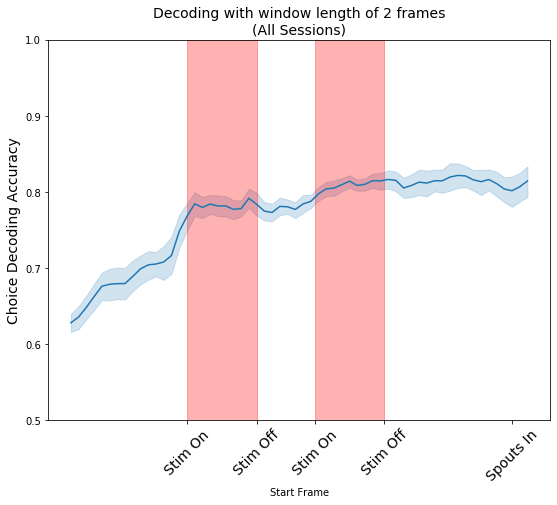

In [36]:
# Visualize accuracy just for window lengths of 2

# Get all the window length 2 accuracies
accuracy_vals = []
start_frames = []
for accuracy in all_accuracy:
    for i in range(accuracy.shape[0]):
        for j in range(120):
            if accuracy[i][j] == 0:
                continue
            accuracy_vals.append(accuracy[i][j])
            start_frames.append(j)
df = pd.DataFrame({
    'Accuracy': accuracy_vals,
    'Frame': start_frames
    })

plt.figure(figsize=(9,7))
ax = sns.lineplot(x="Frame", y="Accuracy", data=df)
plt.title("Decoding with window length of 2 frames\n(All Sessions)", fontsize=14)
plt.ylabel("Choice Decoding Accuracy", fontsize=14)
plt.xlabel("Start Frame")
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
ax.axvspan(30, 30+18, alpha=0.3, color='red')
ax.axvspan(30+33, 30+51, alpha=0.3, color='red')
plt.ylim((0.5, 1))
plt.show()

## Plot of regional importance over time

In [52]:
# Collect coefficient values
coef_values_df = {}
coef_values_df['Trial Event'] = []
coef_values_df['Coefficients'] = []
coef_values_df['Brain Region'] = []
frames = [14, 40, 56, 72, 90]
events = ['Pre-Stim', 'Stim 1', 'Between Stims', 'Stim 2', 'Delay']

# Iterate over each region
for k1 in all_results.keys():
    for k2 in all_results[k1].keys():
        results = all_results[k1][k2]
        len2_results = results[0]
        session = Session(task, k1, k2, access_engram=True, load_behavenet=False)
        reg_indxs = session.neural['reg_indxs_consolidate'].item()
        reg_names = session.neural['reg_indxs_consolidate'].dtype.names
        for idx, reg_name in enumerate(reg_names):
            components = reg_indxs[idx].squeeze()

            # For each component in a region
            for component in components:
                # For each time step, collect the relevant coefficient values
                for idx, log_reg in enumerate(len2_results):
                    if idx not in frames:
                        continue
                    normalized_coefs = normalize(log_reg.coef_).squeeze()
                    coef_values_df['Trial Event'].append(events[frames.index(idx)])
                    coef_values_df['Coefficients'].append(
                        np.abs(normalized_coefs[component-1]) # Components is 1-indexed!
                        )
                    coef_values_df['Brain Region'].append(reg_name)
coef_values_df = pd.DataFrame(data=coef_values_df)

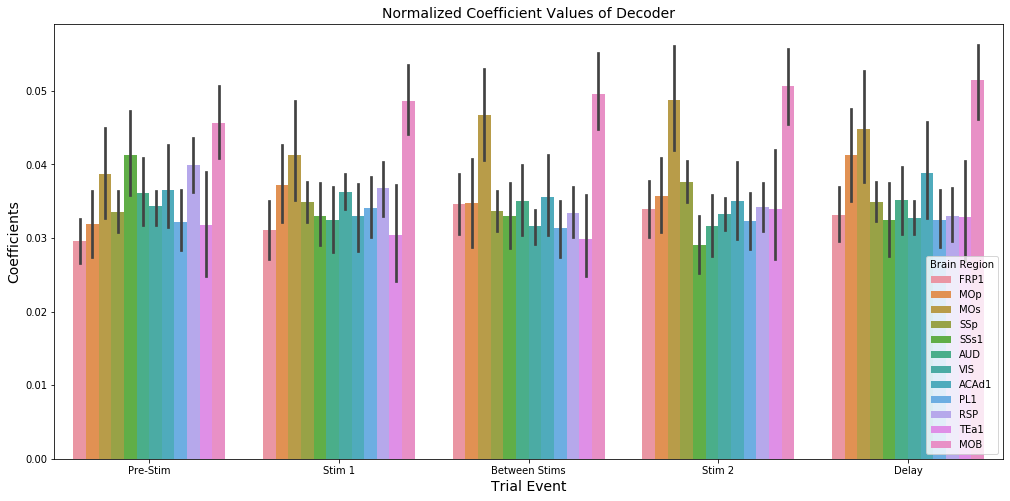

In [55]:
plt.figure(figsize=(17,8))
plt.title("Normalized Coefficient Values of Decoder", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.xlabel("Trial Event", fontsize=14)
ax = sns.barplot(
    x="Trial Event", y="Coefficients", hue="Brain Region", data=coef_values_df
    )

# Collecting the other residual/reconstruction for that one session

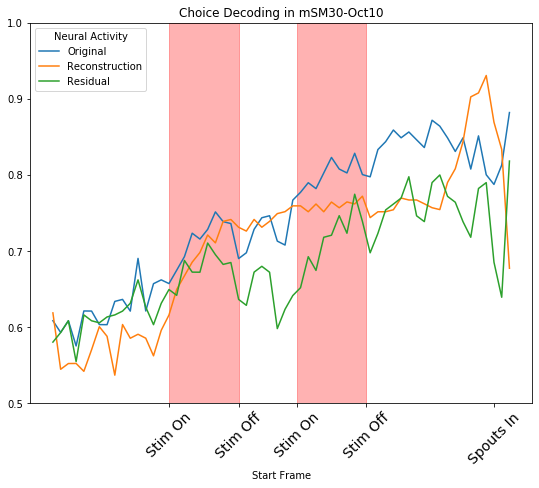

In [60]:
results = all_results['mSM30']['10-Oct-2017']

# Collect the accuracy for original
accuracy_grid = []
for idx, window_length in enumerate(window_lengths):
    window_results = results[idx]
    window_accuracy = []
    for r in window_results:
        if r == None:
            window_accuracy.append(0)#np.isnan)
            continue
        score = np.max(np.mean(r.scores_[1], axis=0))
        window_accuracy.append(score)
    accuracy_grid.append(window_accuracy)
accuracy_grid = np.array(accuracy_grid)
all_accuracy.append(accuracy_grid)

# Visualize accuracy just for window lengths of 2
plt.figure(figsize=(9,7))
accuracy = []
start_frame = []
for idx, val in enumerate(accuracy_grid[0,:]):
    if val == 0:
        continue
    accuracy.append(val)
    start_frame.append(idx)
full_accuracy = accuracy

# Collect for reconstruction
with open("temporaldecoding_reconstructions.p", "rb") as f:
    results = pickle.load(f)
accuracy = []
for frame, log_reg in enumerate(results):
    if log_reg == None:
        continue
    start_frame.append(frame*2)
    accuracy.append(
        np.max(np.mean(log_reg.scores_[1], axis=0))
        )
reconstruction_accuracy = accuracy

# Collect for residual
with open("temporaldecoding_residuals.p", "rb") as f:
    results = pickle.load(f)
accuracy = []
for frame, log_reg in enumerate(results):
    if log_reg == None:
        continue
    start_frame.append(frame*2)
    accuracy.append(
        np.max(np.mean(log_reg.scores_[1], axis=0))
        )
residual_accuracy = accuracy

# Now plot them
plt.plot(np.arange(0,120,2), full_accuracy, label="Original")
plt.plot(np.arange(0,120,2), reconstruction_accuracy, label="Reconstruction")
plt.plot(np.arange(0,120,2), residual_accuracy, label="Residual")
plt.title("Choice Decoding in mSM30-Oct10")
plt.legend(title="Neural Activity")
plt.xlabel("Start Frame")
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.axvspan(30, 30+18, alpha=0.3, color='red')
plt.axvspan(30+33, 30+51, alpha=0.3, color='red')
plt.ylim((0.5, 1))
plt.show()